# COVID Information Detection


As COVID-19 continues to spread across the country and the world, we all must remain vigilant. The changes we have had to make to routines and daily life are extremely hard, but these changes are even more important now and in the future. We must stop the spread of this new and dangerous virus. The more steps you and your family can take to prevent the spread of COVID-19, the safer you will be.

The way this pandemic is spreading, it is creating havoc and there are certain myths and rumors related to this disease. Sometimes a lot of information can also be misguiding. As part of an effort to combat misinformation about coronavirus, we are trying to classify the given dataset by binary classification, in which we will predict on the basis of the information trained, whether the information is Fake or True. This will help common citizens to identify the news related to the pandemic.

Importing Libraries

In [1]:
# !pip3 install textstat
# !pip3 install lexicalrichness
# !pip3 install textblob
# !pip3 install plotly
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords    
stop_words = set(stopwords.words('english'))
from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.pipeline import Pipeline

C:\Users\amrit\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\amrit\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/priyanshi9692/CMPE257-Detect-Covid19-Misinformation/main/corona_fake.csv')

In [3]:
data.head(10)


,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake
5,CORONA UNMASKED: Chinese Intelligence Officer ...,NaN,NaN,NaN
6,NaN,Urgent: Health Bulletin to the Public. Ministr...,Ministry of Health,Fake
7,NaN,"Pls tell ur families, relatives and friendsMOH...",NWLLAB,Fake
8,NaN,SERIOUS EXCELLENT ADVICE by Japanese doctors t...,Japanese doctors treating COVID-19 cases,Fake
9,Basic protective measures against the new coro...,Stay aware of the latest information on the CO...,https://www.who.int/emergencies/diseases/novel...,TRUE


In [4]:
#check the lable values
data['label'].value_counts()

TRUE    584
Fake    345
fake    230
Name: label, dtype: int64

In [5]:
#replace lable value "fake" and "Fake" with "Not Genuine"
# and "True" with "Genuine"

data["label"]= data["label"].str.replace("fake", "Fake ", case = False)

In [6]:
data["label"]= data["label"].str.replace("Fake", "Fake ", case = False)

In [7]:
data['label'].value_counts()

TRUE      584
Fake      575
Name: label, dtype: int64

In [8]:
data["label"]= data["label"].str.replace("True", "Genuine", case = False)

In [9]:
data['label'].value_counts()

Genuine    584
Fake       575
Name: label, dtype: int64

In [10]:
#check if column lable has null value
label_column=data['label'].isnull()
label_column


0       False
1       False
2       False
3       False
4       False
5        True
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15       True
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1134    False
1135    False
1136    False
1137    False
1138    False
1139    False
1140    False
1141    False
1142    False
1143    False
1144    False
1145    False
1146    False
1147    False
1148    False
1149    False
1150    False
1151    False
1152    False
1153    False
1154    False
1155    False
1156    False
1157    False
1158    False
1159    False
1160    False
1161    False
1162    False
1163    False
Name: label, Length: 1164, dtype: bool

In [11]:
#find the row which has lable column null
for i in range (1164):
    if(label_column[i]==True):
        print(i)

5
15
43
131
242


In [12]:
#replace lable column null values
data.loc[5]['label'] = 'Fake'
data.loc[15]['label'] = 'Genuine'
data.loc[43]['label'] = 'Fake'
data.loc[131]['label'] = 'Genuine'
data.loc[242]['label'] = 'Fake'

In [13]:
#check null values of all the columns 
data.isnull().sum()

title     82
text      10
source    20
label      0
dtype: int64

In [14]:
#replace null values with blank 
data=data.fillna(' ')

In [15]:
print(data.isnull().sum())

title     0
text      0
source    0
label     0
dtype: int64


In [16]:
# Combine text and title column to 

data['textdata']=data['text']+' '+data['title']
print(data['textdata'][0])

You just need to add water, and the drugs and vaccines are ready to be administered. There are two parts to the kit: one holds pellets containing the chemical machinery that synthesises the end product, and the other holds pellets containing instructions that telll the drug which compound to create. Mix two parts together in a chosen combination, add water, and the treatment is ready. Due to the recent outbreak for the Coronavirus (COVID-19) the World Health Organization is giving away vaccine kits. Just pay $4.95 for shipping


In [17]:
#Removing punctuations and converting data to lowercase¶
data['textdata'] = data['textdata'].str.replace('[^\w\s]','')
data['textdata'] = data['textdata'].str.lower()

In [18]:
data['textdata'][0]

'you just need to add water and the drugs and vaccines are ready to be administered there are two parts to the kit one holds pellets containing the chemical machinery that synthesises the end product and the other holds pellets containing instructions that telll the drug which compound to create mix two parts together in a chosen combination add water and the treatment is ready due to the recent outbreak for the coronavirus covid19 the world health organization is giving away vaccine kits just pay 495 for shipping'

In [19]:
stop_words = set(stopwords.words('english'))


def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [20]:

'''
Preprocess a string text input.
:parameter
    :parameter text: - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def func_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize 
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming 
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation 
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [22]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amrit\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [23]:

data['total'] = data['textdata'].apply(lambda x: func_preprocess_text(x))

In [24]:
data.head(10)

,title,text,source,label,textdata,total
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake,you just need to add water and the drugs and v...,you just need to add water and the drug and va...
1,,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake,hydroxychloroquine has been shown to have a 10...,hydroxychloroquine ha been shown to have a 100...
2,,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake,fact hydroxychloroquine has been shown to have...,fact hydroxychloroquine ha been shown to have ...
3,,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake,the corona virus is a man made virus created i...,the corona virus is a man made virus created i...
4,,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake,doesnt billgates finance research at the wuhan...,doesnt billgates finance research at the wuhan...
5,CORONA UNMASKED: Chinese Intelligence Officer ...,,,Fake,corona unmasked chinese intelligence officer...,corona unmasked chinese intelligence officer r...
6,,Urgent: Health Bulletin to the Public. Ministr...,Ministry of Health,Fake,urgent health bulletin to the public ministry ...,urgent health bulletin to the public ministry ...
7,,"Pls tell ur families, relatives and friendsMOH...",NWLLAB,Fake,pls tell ur families relatives and friendsmoh ...,pls tell ur family relative and friendsmoh hea...
8,,SERIOUS EXCELLENT ADVICE by Japanese doctors t...,Japanese doctors treating COVID-19 cases,Fake,serious excellent advice by japanese doctors t...,serious excellent advice by japanese doctor tr...
9,Basic protective measures against the new coro...,Stay aware of the latest information on the CO...,https://www.who.int/emergencies/diseases/novel...,Genuine,stay aware of the latest information on the co...,stay aware of the latest information on the co...


In [26]:
data = data.drop("textdata", axis=1)

In [27]:
data['total'][100]

'every virology lab in the world that ha run a genomic analysis of the coronavirus now know that the coronavirus wa engineered by human scientist the proof is in the virus itself the tool for genetic insertion are still present a remnant in the genetic code since these unique gene sequence dont occur by random chance theyre proof that this virus wa engineered by scientist in a lab but the who and cdc are covering up this inconvenient fact in order to protect communist china and it biological weapon program since no government want the public to know the full truth about how frequently governmentrun lab experience outbreak decade ago for example the u army ran an ebola bioweapon lab in the united state where a monkey infected one of the scientist there the strain turned out to be infectious only in monkey not human so the world dodged a bullet but the u army nuked the entire facility with chemical bomb killing all the monkey and wiping out any last remnant of the virus on u soil you can

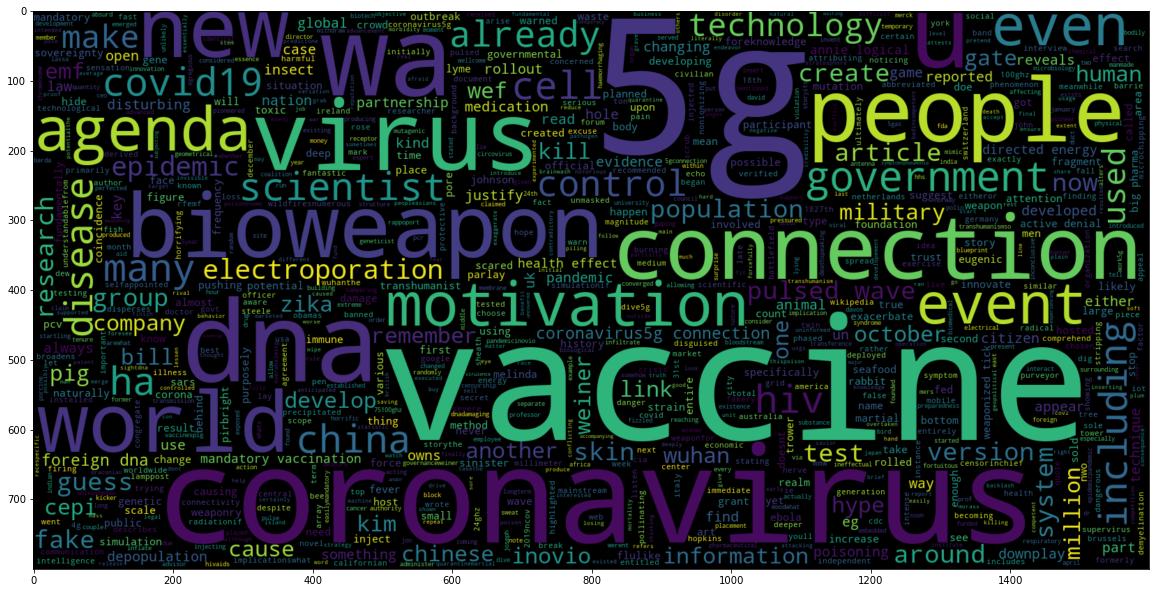

In [28]:
#word cloud vizualization 

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == "Fake"].total))
plt.imshow(wc, interpolation = 'bilinear')

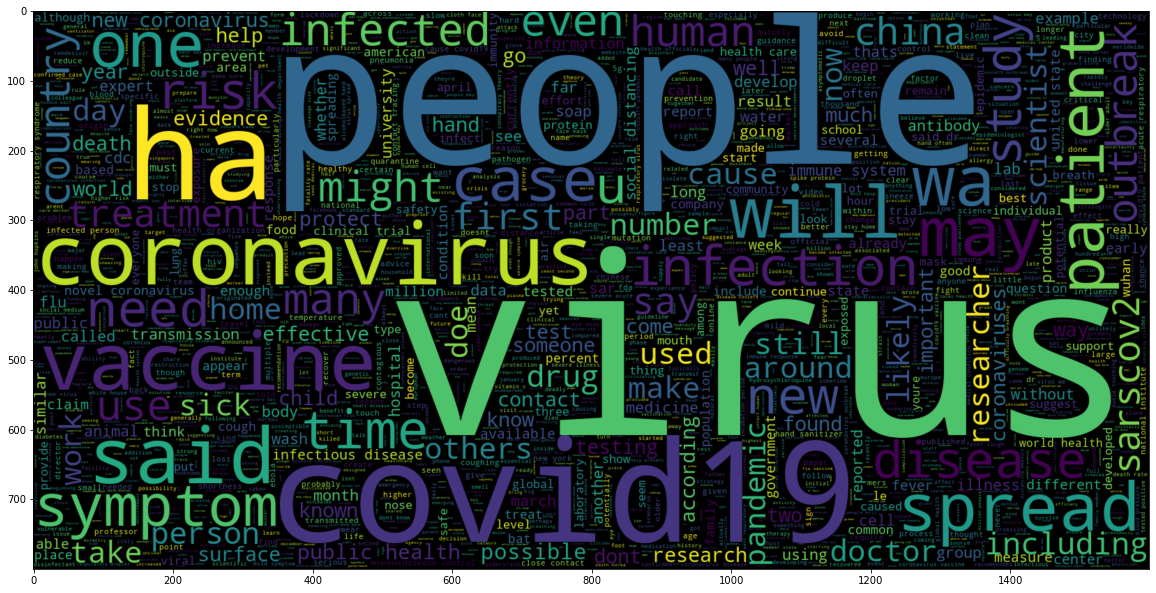

In [29]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == "Genuine"].total))
plt.imshow(wc, interpolation = 'bilinear')

In [30]:
#split the data in train and test 

y=data.label
y

0        Fake  
1        Fake  
2        Fake  
3        Fake  
4        Fake  
5          Fake
6        Fake  
7        Fake  
8        Fake  
9       Genuine
10       Fake  
11       Fake  
12       Fake  
13       Fake  
14      Genuine
15      Genuine
16      Genuine
17      Genuine
18      Genuine
19      Genuine
20      Genuine
21      Genuine
22      Genuine
23      Genuine
24      Genuine
25      Genuine
26      Genuine
27      Genuine
28      Genuine
29      Genuine
         ...   
1134    Genuine
1135    Genuine
1136    Genuine
1137    Genuine
1138    Genuine
1139    Genuine
1140    Genuine
1141    Genuine
1142    Genuine
1143    Genuine
1144    Genuine
1145    Genuine
1146    Genuine
1147    Genuine
1148    Genuine
1149    Genuine
1150    Genuine
1151    Genuine
1152    Genuine
1153    Genuine
1154    Genuine
1155    Genuine
1156    Genuine
1157    Genuine
1158    Genuine
1159    Genuine
1160    Genuine
1161    Genuine
1162    Genuine
1163    Genuine
Name: label, Length: 116

In [31]:
data.drop("label", axis=1,inplace=True)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data['total'], y, test_size=0.2,random_state=102)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(931,) (931,)
(233,) (233,)


In [33]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.80)  
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [34]:
xgb_model = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
xgb_model.fit(tfidf_train, y_train)
pred3 = xgb_model.predict(tfidf_test)

print('Accuracy of XGBoost on test set:',accuracy_score(y_test, pred3))


Accuracy of XGBoost on test set: 0.8969957081545065


In [35]:
print("Classification Report for XGBoost Model: \n", metrics.classification_report(y_test, pred3))

Classification Report for XGBoost Model: 
               precision    recall  f1-score   support

      Fake         0.93      0.88      0.90       126
     Genuine       0.87      0.92      0.89       107

   micro avg       0.90      0.90      0.90       233
   macro avg       0.90      0.90      0.90       233
weighted avg       0.90      0.90      0.90       233



confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


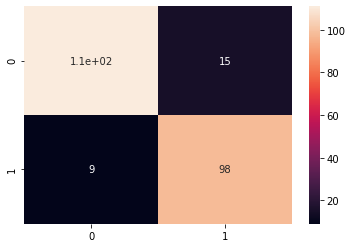

In [36]:
cm = confusion_matrix(y_test, pred3)
import seaborn as sns

print("confusion matrix: \n", sns.heatmap(cm, annot = True))

In [37]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.80)),
    ('clf',xgb_model)])

In [38]:

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ht=None, seed=2, subsample=0.7,
       tree_method='exact', validate_parameters=1, verbosity=None))])

In [39]:

result=pipeline.predict(["One of the challenges being faced worldwide is the rate of infection of health professionals while treating COVID-19 patients.  2016 statistics show the following picture of Rwanda’s health sector: 1/50,505 ground ambulance / population Ratio; 1/10,055 Doctor/population ratio; 1/1,094 Nurse/population ratio; 1/10,500 Laboratory technicians /population ratio. Although Rwanda is on track to meeting most of the required quota, the country cannot afford the set back that a pandemic like COVID-19 among health professionals would cause. To minimize contact time with confirmed cases and therefore reducing the risk of contamination of health professionals in COVID-19 treatment centres, robots were deployed. At Gatenga and Kanyinya treatment centres in Kigali City, visits by medical staff to patients went from 3-4 to 2 per day since May 2020. The 5 human-size robots are programmed to perform temperature screening, take readings of vitals, deliver video messages and detect people not wearing masks then instruct them to wear masks properly. On Tuesday, May 19 at the Kanyinya COVID-19 Treatment Centre, the 5 robots were launched by the Ministry of Health. Named in Kinyarwanda, Akazuba, Ikirezi, Mwiza, Ngabo, and Urumuri are made by Zora Bots, a Belgian company specialised in robotics. They were acquired through a partnership between the UNDP Rwanda Accelerator Lab (AccLab) and the Ministry of ICT and Innovation.  Each robot costs about $30,000. Urumuri is currently deployed at the Kigali International Airport with the capacity to screen 50 to 150 people per minute and report abnormalities to officers on duty. As Rwanda is reopening Kigali International Airport for commercial international flights from 1st of August, Urumuri will allow to speed up mass screenings of fever for passengers as they land. Smart anti-epidemic robots have been used in Asia to help flatten the COVID-19 curve. The pandemic has proven to be a crosscutting challenge affecting Rwanda in all sectors (Health, Economy, Education, Agriculture, …). It therefore requires different sometimes innovative solutions with available resources like robots."])
print(result)

['Genuine']
